# The 2D Ising model

As an example for a magnetic material we will simulate the **2D Ising model**. We will use a Markov Chain Monte Carlo approach with Metropolis sampling to simulate configurations of the chain at a temperature $T$.

$$
H = -\epsilon \sum_{(i,j)} s_i s_j
$$

The interaction is over nearest neighbors $(i,j)$ only.

In [85]:
import numpy as np
import scipy.special
import matplotlib.pyplot as plt
plt.matplotlib.style.use('ggplot')

import tqdm

rng = np.random.default_rng(seed=20220428)

In [182]:
# loosely based on Computational Modelling Ch 11


class SpinLattice:
    def __init__(self, N, kT=1.0, p=0.5):
        """Set up 2D lattice with NxN spins, fraction p flipped down"""
        self.N = N
        self.Nspins = N*N
        self.kT = kT
        self.beta = 1/self.kT
        # initialize by flipping a spin to down with probability p
        self.spins = np.where(rng.uniform(size=(N, N)) <= p, -1, 1)
        self.E = None
        self.M = None
        
    def energy_slow(self):
        s = model.spins
        E = 0
        for i in range(self.N):
            for j in range(self.N):
                # PBC taken into account with i-1 and (i+1) % N
                E -= s[i, j] * (s[i-1, j] + s[(i+1) % self.N, j]
                                  + s[i, j-1] + s[i, (j+1) % self.N])
        E /= 2   # double counting of interactions
        return E
        
    def energy(self):
        """total energy in units of epsilon"""
        # for PBC, augment boundaries
        s = np.zeros((self.N+2, self.N+2), dtype=int)
        s[1:-1, 1:-1] = self.spins
        s[0] = s[-2]             # periodic boundary conditions: left
        s[-1] = s[1]             # pbc: right
        s[:, 0] = s[:, -2]       # pbc: bottom
        s[:, -1] = s[:, 1]       # pbc: top
        
        # 1/2 because double counting
        E = -0.5 * np.sum(s[1:-1, 1:-1] * 
                   (s[:-2, 1:-1] + s[2:, 1:-1] + s[1:-1, :-2] + s[1:-1, 2:]))   
        return E
    
    def magnetization(self):
        return float(np.sum(self.spins))
    
    def _update(self, i, j, randfloat):
        """Update of a single spin i with Metropolis criterion.
        
        Generate a random float 0 <= x < 1 for Metropolis in advance.
        """
        
        s = self.spins
        
        accept = False
        dE = 2 * s[i, j] * (s[i-1, j] + s[(i+1) % self.N, j]
                          + s[i, j-1] + s[i, (j+1) % self.N])  # with periodic boundary conditions
        if dE <= 0:
            accept = True
        else:
            p = np.exp(-self.beta * dE)
            accept = (randfloat < p)
            
        if accept:
            s[i, j] *= -1
        
        return accept
    
    def run(self, iterations=1000, verbose=True):
        """Run `iterations` sweeps of updates."""
        energies = []
        magnetizations = []
        n_accept = 0
        for iteration in tqdm.tqdm(range(iterations), disable=not verbose):
            for (i, j), x in zip(rng.integers(low=0, high=self.N, dtype=int, size=(self.Nspins, 2)),
                                 rng.uniform(size=self.Nspins)):
                accept = self._update(i, j, x)
                n_accept += accept
            energies.append(self.energy())
            magnetizations.append(self.magnetization())
            
        acceptance_ratio = n_accept / (self.Nspins * iterations)
        self.E = np.array(energies)
        self.M = np.array(magnetizations)
        
        return self.E, self.M, acceptance_ratio
    
    def average(self, a, burnin):
        start = int(round(burnin * len(a)))
        return np.average(a[start:])
    
    def E_average(self, burnin=0.1):
        """<E>/N (with initial burnin % removed)"""
        return self.average(self.E, burnin)/self.Nspins
    
    def M_average(self, burnin=0.1):
        """<M>/N (with initial burnin % removed)"""
        return self.average(self.M, burnin)/self.Nspins
    
    def plot(self):
        fig, axes = plt.subplots(1, 3, figsize=(10, 3))

        axes[0].set_title(r"$kT/\epsilon =$" f"{self.kT:.1f}")
        axes[0].grid(False)
        axes[0].pcolormesh(self.spins)
        axes[0].set_aspect("equal")

        axes[1].set_title(r"$\langle E\rangle/N\epsilon =$" f"{self.E_average():.3f}")
        axes[1].plot(self.E/self.Nspins)
        axes[1].set(xlabel=r"MC step", ylabel=r"$E/N\epsilon$");

        axes[2].set_title(r"$\langle M\rangle/N =$" f"{self.M_average():.3f}")
        axes[2].plot(self.M/self.Nspins)
        axes[2].set(xlabel=r"MC step", ylabel=r"$M/N$")

        fig.tight_layout()
        
        return fig

def E_analytical(kT): # 2d
    # epsilon = 1
    beta = 1/kT
    m = 4 * np.sinh(2*beta)**2 / np.cosh(2*beta)**4
    return -2 * np.tanh(2*beta) - 2 * (np.sinh(2*beta)**2 - 1)/np.sinh(4*beta) * (
        2/np.pi * scipy.special.ellipk(m) - 1)
    
def M_analytical(kT, Tc=2.2692):
    below = kT < Tc
    beta = 1/kT
    M = np.zeros_like(kT)
    M[below] = (1 - np.sinh(2*beta[below])**(-4))**(1/8)
    return M

In [170]:
%timeit model.energy()

806 µs ± 14.3 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In [171]:
%timeit model.energy_x()

17.8 µs ± 416 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


In [175]:
model.energy(), model.energy_x()

(-2048.0, -2048.0)

In [173]:
model.kT

5.0

## Explore the 2D Ising model at different temperatures

In [177]:
model = SpinLattice(32, kT=1,  p=0.5)

E, M, r = model.run(iterations=2000)
print(r)
print(model.E_average(), model.M_average())

100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 122.24it/s]

0.004029296875
-1.9968359375 0.9991937934027778


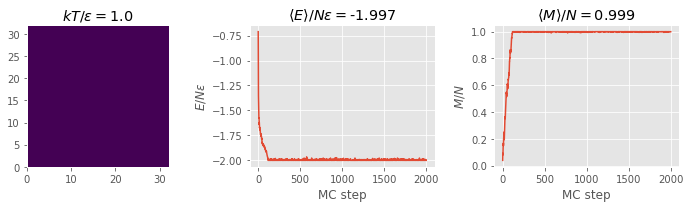

In [178]:
model.plot();

In [152]:
model = SpinLattice(32, kT=2.,  p=0.5)

E, M, r = model.run(iterations=2000)
print(r)
print(model.E_average(), model.M_average())

100%|██████████████████████████████████████| 2000/2000 [00:18<00:00, 108.68it/s]

0.094900390625
-1.7243077256944443 0.8538096788194445


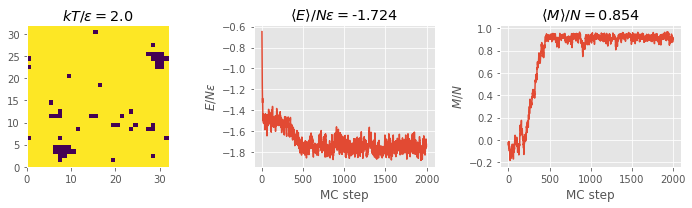

In [153]:
model.plot();

In [154]:
model = SpinLattice(32, kT=2.4,  p=0.5)

E, M, r = model.run(iterations=2000)
print(r)
print(model.E_average(), model.M_average())

100%|██████████████████████████████████████| 2000/2000 [00:17<00:00, 112.69it/s]

0.2880751953125
-1.18380859375 -0.11831705729166667


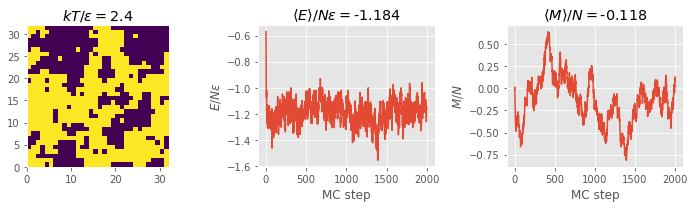

In [155]:
model.plot();

In [156]:
model = SpinLattice(32, kT=4)

E, M, r = model.run(iterations=2000)
print(r)
print(model.E_average(), model.M_average())

100%|██████████████████████████████████████| 2000/2000 [00:16<00:00, 123.34it/s]

0.60820703125
-0.5587087673611111 0.0004177517361111111


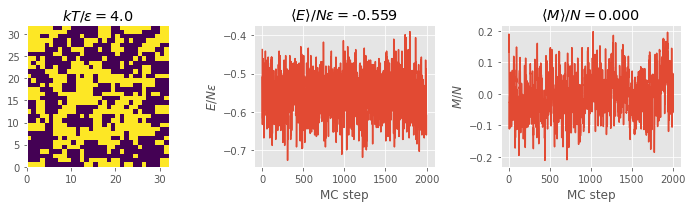

In [157]:
model.plot();

## Temperature dependence of $E$ and $M$

The dependence of the average energy per spin $\langle E \rangle/N$ on the temperature $T$ for the 2D spin lattice (Ising model) is

$$
\frac{\langle E \rangle}{N\epsilon} = -2\tanh 2\beta\epsilon -2 \frac{\sinh^2 2\beta\epsilon -1}{\sinh 4\beta\epsilon} \left(\frac{2}{\pi}K(m) -1 \right)
$$

with the parameter

$$
m = \frac{4 \sinh^2 2\beta\epsilon}{\cosh^4 2\beta\epsilon}. 
$$

The average magnetization per spin is

$$
\frac{\langle M \rangle}{N} = \begin{cases}
(1 - \sinh^{-4} 2\beta\epsilon)^{1/8}, \quad T < T_c\\
0, \quad T \ge Tc
\end{cases}
$$

with the critical temperature $k T_c/\epsilon \approx 2.2692$ at which the phase transition occurs.


Run the simulation for a range of temperatures (measured in $kT$); note that we speed up the initial equilibration phase by setting the average spin distribution close to the expected equilibrium value by tuning the parameter `p`. The exact value of `p` is not important and the correct observables should be obtained independent of `p`, just the required number of `iterations` may increase.

In [183]:
temperatures = np.linspace(0.1, 5, 50)

Nspins = 32
energy = np.zeros_like(temperatures)
magnetization = np.zeros_like(temperatures)

for j, kT in tqdm.tqdm(enumerate(temperatures), total=len(temperatures)):
    p = 0.05 if kT < 2.3 else 0.5
    model = SpinLattice(Nspins, kT=kT, p=p)
    model.run(iterations=1000, verbose=False)
    energy[j] = model.E_average()
    magnetization[j] = model.M_average()


100%|███████████████████████████████████████████████████████████████████████████████████████| 50/50 [05:20<00:00,  6.41s/it]


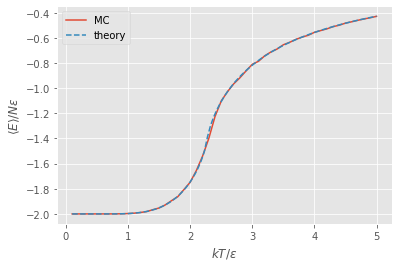

In [186]:
kT = np.linspace(0.1, 5, 100)

plt.plot(temperatures, energy, label="MC")
plt.plot(kT, E_analytical(kT), '--', label="theory")
plt.xlabel(r"$kT/\epsilon$")
plt.ylabel(r"$\langle E\rangle/N\epsilon$")
plt.legend();

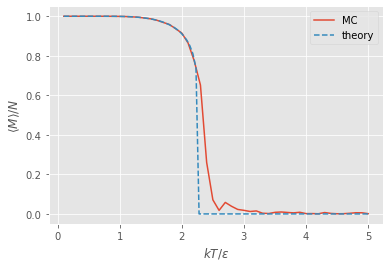

In [187]:
plt.plot(temperatures, np.abs(magnetization), label="MC")
plt.plot(kT, M_analytical(kT), "--", label="theory")
plt.xlabel(r"$kT/\epsilon$")
plt.ylabel(r"$\langle M \rangle/N$")
plt.legend();